In [1]:
from architectures import *
from training_gan import *

import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax.random import PRNGKey as jkey
from flax.core import FrozenDict
from flax.training.train_state import TrainState as RawTrainState
from imax import transforms
from chex import Array, Scalar, PRNGKey
from PIL import Image

# Czy sieci neuronowe śnią o ciastach marchewkowych?
## To chyba nie jest oryginalny Breitling, prawda?
Model dyskriminatora:
```python
def conv_block(x: Array, features: int, training: bool) -> Array:

    x = nn.Conv(features=features, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    return x


class Discriminator(nn.Module):
    
    @nn.compact
    def __call__(self, batch: Array, training: bool):
        
        batch_size = batch.shape[0]
        x = batch / 255
        x = conv_block(x, 64, training)
        x = conv_block(x, 128, training)
        x = conv_block(x, 128, training)
        x = jnp.reshape(x, (batch_size, -1))
        x = nn.Dropout(rate=0.2, deterministic=not training)(x)
        x = nn.Dense(features=1)(x)
        x = nn.sigmoid(x)
        
        return x
```

## Skoro nie widać różnicy..?
Model generatora:
```python
def trans_conv_block(x: Array, features: int) -> Array:

    x = nn.ConvTranspose(features=features, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    return x


class Generator(nn.Module):

    @nn.compact
    def __call__(self, batch: Array):

        batch_size = batch.shape[0]
        x = batch
        x = nn.Dense(features=8192)(x)
        x = jnp.reshape(x, (batch_size, 8, 8, 128))
        x = trans_conv_block(x, 128)
        x = trans_conv_block(x, 256)
        x = trans_conv_block(x, 512)
        x = nn.Conv(features=3, kernel_size=(5, 5), strides=(1, 1), padding='SAME')(x)
        x = nn.sigmoid(x)

        return x
```

In [2]:
# Generuje fotografie z losowego szumu
state_gen = create_Generator(42)
dummy_batch_vectors = jax.random.normal(jkey(42), shape=(2, 128)) * jnp.array([[1], [25]])
dummy_pred = generate(state_gen, dummy_batch_vectors)

Fotografia wygenerowana na podstawie losowego szumu $\mathcal{N}(0, 1)$:

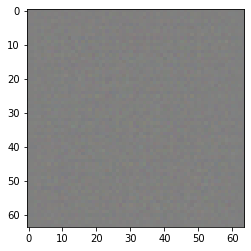

In [3]:
plt.imshow(jnp.squeeze(dummy_pred[0]));

Fotografia wygenerowana na podstawie losowego szumu $\mathcal{N}(0, 25)$:

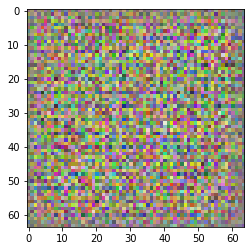

In [4]:
plt.imshow(jnp.squeeze(dummy_pred[1]));

## I zebrano jeszcze dwanaście koszy ułomków

In [13]:
raw_galaxies_path = "datasets/galaxies_raw"
files = os.listdir(raw_galaxies_path)
load_galaxy = lambda file: jnp.array(Image.open(os.path.join(raw_galaxies_path, file)).resize((64, 64)))
images = jnp.array(list(map(load_galaxy, files)))

Przykładowe egzemplarze datasetu *galaxies* utworzonego z uyciem biblioteki *jmd_imagescraper*:

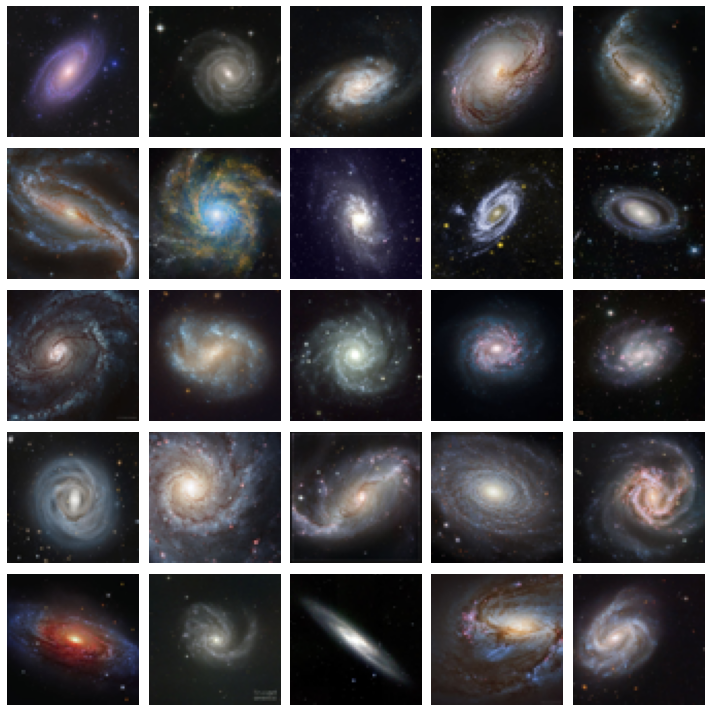

In [14]:
plot_samples(jkey(42), images, subplots_shape=(5, 5))

### Data augmentation
Do operacji "data augmentation" skorzystałem z bibliotki *imax*, która zapewnia mi potrzebne transformacje (odbicia, rotacje, translacje i skalowanie). Ponizszy kod przedsawia stochastyczną modyfikację pojedynczego obrazka, poprzez złozenie operacji obrotu, odbicia w osi pionowej, powiększenia oraz przesunięcia:

In [8]:
def augmentat_img(img, key: PRNGKey):

    key_1, key_2, key_3, key_4, key_5, key_6 = jax.random.split(key, 6)

    rot = transforms.rotate(
        rad=jax.random.uniform(key_1, minval=-jnp.pi / 16, maxval=jnp.pi / 16)
    )
    flip = transforms.flip(
        horizontal=jax.random.uniform(key_2) < 0.5,
        vertical=False
    )
    scale = transforms.scale(
        jax.random.uniform(key_4, minval=1.0, maxval=1.25),
        jax.random.uniform(key_4, minval=1.0, maxval=1.25)
    )
    translate = transforms.translate(
        jax.random.uniform(key_5, minval=-4.0, maxval=4.0),
        jax.random.uniform(key_6, minval=-4.0, maxval=4.0)
    )

    return transforms.apply_transform(img, flip @ rot @ translate @ scale, mask_value=-1)

Data augmentation na małym zbiorze danych (5-elementowym):

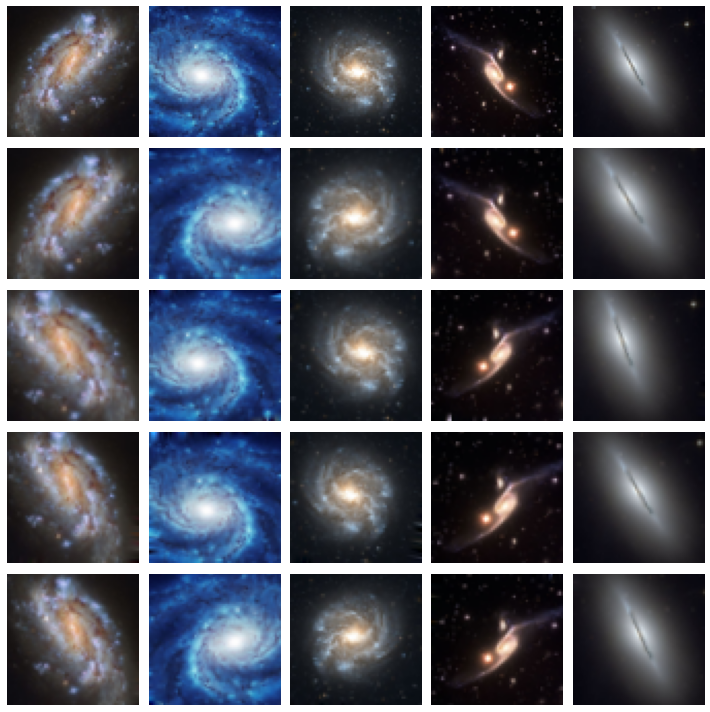

In [9]:
small_ds = images[:5]

key = jkey(44)
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(10, 10)
for i in range(5):
    ax = axes[0, i]
    ax.imshow(small_ds[i])
    ax.axis('off')
for j in range(4):
    for i in range(5):
        key, augment_key = jax.random.split(key)
        ax = axes[1 + j, i]
        ax.imshow(augmentat_img(small_ds[i], augment_key))
        ax.axis('off')
fig.tight_layout()
plt.show()

## Work it harder, make it better
### Prosty rozruch
Przygotowałem model składający się z 2 gęsto połączonych warstw o szerokościach kolejno 8 i 3, aktywowanych funkcją ReLU. W celu wyliczania pochodnych cząstkowych, maskowałem gradient optymalizatora pod odpowiednią warstwą:
```python
opt = optax.multi_transform(
    {"sgd": optax.sgd(learning_rate=lr, momentum=momentum), "zero": zero_grads()},
    {"Dense_0": "sgd", "Dense_1": "zero"}
)
```

Zatem za maskowanie gradientu odpowiada optymalizator, który jest częścią stanu modelu. W moim kodzie, optymalizator jest odpowiednio inicjowany w funkcji `create_SimpleModel`.
Ponizej implementacja treningu z tak maskowanym gradientem oraz wykres krzywej kosztu, obliczanego jako odległośc średniej z wyjścia modelu a liczbą 42:

/Users/wciezobka/ncn/pyncn310/lib/python3.10/site-packages/optax/_src/combine.py:129: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  label_set = set(jax.tree_leaves(labels))


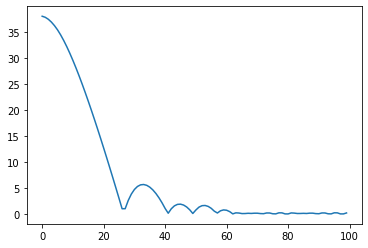

In [10]:
def dummy_loss(params: FrozenDict, batch: Array, state: RawTrainState):

    logits = state.apply_fn(
        {'params': params},
        batch
    )
    
    return jnp.abs(42 - jnp.mean(logits))


@jax.jit
def step_fn(state: RawTrainState, batch: Array):

    # Compute masked gradients
    grad_fn = jax.value_and_grad(dummy_loss)
    loss, grads = grad_fn(state.params, batch, state)

    # Correct weights in the training state
    new_state = state.apply_gradients(grads=grads)

    return new_state, loss


batch = jax.random.uniform(jkey(42), shape=(8, 3)) * 10
state = create_SimpleModel(batch, jkey(42), lr=0.01)

init_params = state.params
loss_acc = []
for i in range(100):

    state, loss = step_fn(state, batch)
    loss_acc.append(loss)
    

final_params = state.params
plt.plot(jnp.arange(len(loss_acc)), jnp.array(loss_acc));

Weryfikacja czy faktycznie wagi w warstwie I pozostały bez zmian:

In [11]:
jax.tree_util.tree_map(lambda x, y: jnp.array_equal(x, y), init_params, final_params)

{'Dense_0': {'bias': DeviceArray(False, dtype=bool),
  'kernel': DeviceArray(False, dtype=bool)},
 'Dense_1': {'bias': DeviceArray(True, dtype=bool),
  'kernel': DeviceArray(True, dtype=bool)}}

PS Co prawda takie maskowanie działa, jednak podczas dalszego przebiegu cwiczenia okazało się zbędne. JAX jest na tyle elastyczą biblioteką, ze pozwala dokładnie wyspecyfikowac po czym rozniczkujemy. Domyślnie funkja `jax.grad(some_fun)` liczy pochodne funkcji `some_fun` po jej pierwszym argumencie, co pozwoliło mi w łatwy sposób określac czy minimalizuje stan dyskryminatora czy stan generatora.

### Uczenie dyskryminatora

Trening modelu rozdzieliłem do dwóch funkcji. Pierwsza z nich (zewnętrzna): 
- tworzy batch sztucznie wygenerowanych obrazków
- konkatenuje go do batcha obrazków autentycznych (z dysku)
- tworzy etykiety i następnie je zaszmia
- wywołuje funkcję obliczającą gradienty i je aplikuje do stanów dyskryminatora i generatora
- Oblicza metryki accuracy
- Zwraca zmodyfikowane stany i metryki  

Druga funkcja wewnętrzna jest odpowiedzialna za wyliczenie kosztu i gradientu po koszcie. Ta funkcja równierz modyfikuje lekko stan,
poniewaz to tutaj zmieniane sa statystyki przez *batch normalization*. Kod obu funkcji (najpierw wenętrzna obliczająca gradienty):
```python
@jax.jit
def compute_dis_grads(state_dis: TrainState, batch: Array, labels: Array):
    """Computes discriminators gradients and loss of a single batch"""

    def loss_fn(params, batch_stats):

        logits, mutated_vars = state_dis.apply_fn(
            {'params': params, 'batch_stats': batch_stats},
            batch,
            training=True,
            mutable=['batch_stats'],
            rngs={'dropout': jax.random.PRNGKey(42)}
        )
        logits = jnp.squeeze(logits)
        loss = binary_cross_entropy(logits=logits, labels=labels)

        return loss, (mutated_vars, logits)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (mutated_vars, logits)), grads = grad_fn(state_dis.params, state_dis.batch_stats)

    new_state = TrainState(
        step=state_dis.step,
        apply_fn=state_dis.apply_fn,
        params=state_dis.params,
        tx=state_dis.tx,
        opt_state=state_dis.opt_state,
        batch_stats=mutated_vars['batch_stats']
    )
    
    return grads, new_state, loss, logits


@jax.jit
def discriminator_train_step(
    key: PRNGKey,
    state_dis: TrainState,
    state_gen: TrainState,
    batch_authentic: Array
) -> Tuple[TrainState, Scalar, Scalar, Scalar]:

    batch_key, uniform_key_1, uniform_key_2 = jax.random.split(key, 3)
    batch_seed_vector = jax.random.normal(batch_key, shape=(BATCH_SIZE, 128))

    batch_syntetic = generateV2(state_gen, batch_seed_vector)
    batch_merged = jnp.concatenate((batch_authentic, batch_syntetic))
    labels = jnp.concatenate((jnp.ones(BATCH_SIZE), jnp.zeros(BATCH_SIZE)))
    noise = jnp.concatenate((
        jax.random.uniform(uniform_key_1, (BATCH_SIZE,), minval=-0.05, maxval=0.0),
        jax.random.uniform(uniform_key_2, (BATCH_SIZE,), minval=0.0, maxval=0.05)
    ))
    labels += noise

    grads, state_dis, loss, logits = compute_dis_grads(state_dis, batch_merged, labels)
    state_dis = state_dis.apply_gradients(grads=grads)

    # Compute discriminator accuracy (acc_real, acc_fake)
    acc_real = jnp.sum(logits[:BATCH_SIZE]) / BATCH_SIZE
    acc_fake = jnp.sum(1 - logits[BATCH_SIZE:]) / BATCH_SIZE

    return state_dis, loss, acc_real, acc_fake
```

### Uczenie generatora
Schemat uczenia generatora jest podony, równierz podzielony na 2 funkcje. Tym razem zewnętrzna funkcja jest bardzo prosta, poniewaz jest odpowiedzialna jedynie za wywołanie wewnętrznej liczącej gradienty oraz obliczenie metryki accuracy. Wewnętrzna z kolei jest bardzo podobna do funkcji `compute_dis_grads` jedynie loss liczymy inaczej, poniewaz najpierw generujemy syntetyczny batch aktualnym generatorem, potem klasyfikujemy "zamrozonym" dyskryminatorem i liczymy entropie krzyzowa po wynikach.

```python
@jax.jit
def compute_gen_grads(state_dis: TrainState, state_gen: TrainState, seed_vector: Array):

    def loss_fn(params, batch_stats):

        batch_syntetic, mutated_vars = state_gen.apply_fn(
            {'params': params, 'batch_stats': batch_stats},
            seed_vector,
            training=True,
            mutable=['batch_stats']
        )
        logits = discriminate(state_dis, batch_syntetic)
        loss = binary_cross_entropy(logits, GENERATOR_LABELS)

        return loss, (mutated_vars, logits)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (mutated_vars, logits)), grads = grad_fn(state_gen.params, state_gen.batch_stats)

    new_state_gen = TrainState(
        step=state_gen.step,
        apply_fn=state_gen.apply_fn,
        params=state_gen.params,
        tx=state_gen.tx,
        opt_state=state_gen.opt_state,
        batch_stats=mutated_vars['batch_stats']
    )

    return grads, new_state_gen, loss, logits


@jax.jit
def generator_train_step(state_dis: TrainState, state_gen: TrainState, seed_vector: Array):

    grads, state_gen, loss, logits = compute_gen_grads(state_dis, state_gen, seed_vector)
    state_gen = state_gen.apply_gradients(grads=grads)

    # Compute generator accuracy (acc_gen)
    acc_gen = jnp.sum(logits) / BATCH_SIZE

    return state_gen, loss, acc_gen
```

### Monitorowanie efektów
W moim frameworku (w bibliotece *flax*) znalazłem funkcje `save_checkpoint` odpowiedzialne za serializacje i zapis stanu modelu, tak zwane checkpointy. Uzyłem tej funkcjonalności do monitorowania stanu uczenia. Opakowałem je w funkcje która dodatkowo generuje obrazki na podstawie aktualnego stanu generatora oraz `MONITOR_VECTORS` czyli zbioru stałych wektorów z *latent space* uzywanych jako wyznacznik jakosci generowanych obrazkow. Ponizej najistotniejszy fragment kodu realizującego opisaną funkcjonalnośc:
```python
try:
    save_checkpoint(
        checkpoint_dir,
        state_dis,
        epoch,
        prefix="checkpoint-discriminator_",
        overwrite=True,
        keep_every_n_steps=1
    )
    save_checkpoint(
        checkpoint_dir,
        state_gen,
        epoch,
        prefix="checkpoint-generator_",
        overwrite=True,
        keep_every_n_steps=1
    )
except flax.errors.InvalidCheckpointError:
    print(f'[Warning] Could not save state after epoch {epoch}!')
    return

try:
    save_generated()    # funkcja zapisująca subplot z obrazkami wygenerowanymi na podstawie MONITOR_VECTORS
except:
    print(f'[Warning] Could not save generated monitor images after epoch {epoch}!')
```

\* Efekty treningu przedstawię w osobnej sekcji **Trening**

## Pozegnanie ze szkocką kratą
### Alternatywny generator
Model alternatywnego generatora z upsamplingiem oraz konwolucjami (zwykłymi):
```python
def upsampling_block(x: Array, features: int, training: bool) -> Array:

    # Nearest Neighbour upsampling
    x = jax.image.resize(x, shape=(x.shape[0], x.shape[1] * 2, x.shape[2] * 2, x.shape[3]), method="nearest")

    # 1st conv block
    x = nn.Conv(features=features, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training, momentum=0.9)(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    # 2nd conv block
    x = nn.Conv(features=features, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training, momentum=0.9)(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    return x


class GeneratorV2(nn.Module):

    @nn.compact
    def __call__(self, batch: Array, training: bool):

        batch_size = batch.shape[0]
        x = batch
        x = nn.Dense(features=8192)(x)
        x = jnp.reshape(x, (batch_size, 8, 8, 128))
        x = upsampling_block(x, 64, training)
        x = upsampling_block(x, 128, training)
        x = upsampling_block(x, 256, training)
        x = nn.Conv(features=3, kernel_size=(5, 5), strides=(1, 1), padding='SAME')(x)
        x = nn.sigmoid(x)

        return x
```

\* Efekty treningu przedstawię w osobnej sekcji **Trening**

## Trening

Trening GAN'a okazał się bardzo uciąliwy niezaleznie od uzytej wersji generatora. Zacząłem od treningu z wersją generatora bez interpolacji, jednak brak jakichkolwiek sensownych wyników na zbiorze treningowym *galaxies* zmotywował mnie do wykonania najpierw części implementacyjnej zadania -- czyli napisania generatora w wersji z interpolacją (opisanego w poprzedniej sekcji), a dopiero później do wytrnowania któregokolwiek z modeli. Aby osiągnąc prezentowalne wyniki, wykonałem ponizsze eksperymenty:
* Dobór hiperparametrów $lr$, $\beta_{1}$, $\beta_{2}$ optymalizatora **Adam** zarówno dla dyskryminatora jak i generatora
* Modyfikacja modelu Dyskryminatora poprzez redukcję liczby filtrów w warstwach konwolucyjnych (np. do 16, 16, 32) lub zwiększenia dropout'u, oba te zabiegi miały na celu zmniejszenia ekspresywności dyskryminatora
* Modyfikację stosunków kroków treningowych generatora do dyskryminatora z 1/1 na 2/1
* Dobór odpowiednio łatwego datasetu (*galaxies*, *squares*, *amanita*, *anime*)

### Eksperymenty na zbiorze *squares*

Uznałem ze moze zbiór *galaxies* składający się z 624 obrazków galaktyk z *duckduckgo* jest nieodpowiedni/zbyt trudny. Najpierw więc wygenerowałem sztuczny zbiór *squares* w celu debugu mojej architektury. Zbiór *squares* składa się z 200 obrazków powstałych poprzez augmentacji i dodanie szumu gaussowskiego do ponizszego obrazka:

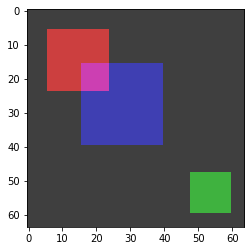

In [12]:
simple_img = jnp.ones((64, 64, 3)) * 0.25
simple_img = simple_img.at[6:24, 6:24, 0].set(0.8)
simple_img = simple_img.at[48:60, 48:60, 1].set(0.7)
simple_img = simple_img.at[16:40, 16:40, 2].set(0.7)

plt.imshow(simple_img);

Uzywając generatora w wersji I (bez interpolacji), odpowiednia redukcja modelu dyskryminatora i tuning hiperparametrów przyniosły rezultaty i juz po kilkudziesięciu epokach udawało mi się generowac kwadraty. Metryki:  
<img src="checkpoints/squares/test_2/metrices/metrices.png" style="width:300px;">

PS. Accuracy >1 to moj błąd w kodzie ntórego nie udało mi się zdiagnozowac.  

Przykład generacji po 60 epokach (najbardziej jakościowe obrazki generowane z `MONITOR_VECTORS`):  
<img src="checkpoints/squares/test_2/generated/checkpoint_60/monitor_3.png" style="width:300px;">

### Eksperymenty na zbiorze *galaxies*

Po udanym eksperymentcie z kwadratami, podekscytowałem się i doszedłem do wniosku ze kluczem do udanego treningu jest odpowiedni dobór hiperparametrów do datasetu. Zatem wróciłem do zbioru galaktyk i zacząłem eksperymentowa z parametrami optymalizatora, dropotem oraz liczbą filtrów w dyskryminatorze. Na początku miałem problemy ze zbieznością (ang. *convergance failure*), poniewaz *loss* dyskryminatora spadał mi prawie do zera, a koszt generatora rósł do wartości ~3.0 i tam się utrzymywał. Jednak po konsultacji z kolegą oraz przeczytaniu ciekawego [tekstu](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/) o problemach z treningiem GAN'ów, udało mi się dostosowa swój model i osiągnąłem przebieg w którym generator faktycznie rywalizował z dyskryminatorem.

Metryki:  
<img src="checkpoints/galaxies/seed_73512/metrices/metrices.png" style="width:300px;">

Przykładowa "galaktyka" wygenerowana po 80 epoce:  
<img src="checkpoints/galaxies/seed_73512/generated/checkpoint_80/monitor_2.png" style="width:300px;">

Inny ciekawy przebieg na tym zbiorze, w którym początek treningu wygląda jakby wystąpiło zjawisko ang. *mode collapse*.  
Metryki:  
<img src="checkpoints/galaxies/seed_21537/metrices/metrices.png" style="width:300px;">

Przykładowa "galaktyka" wygenerowana po 80 epoce:  
<img src="checkpoints/galaxies/seed_21537/generated/checkpoint_150/monitor_4.png" style="width:300px;">

### Eksperymenty na zbiorze *amanita*

Wyniki na zbiorze galaktyk nie okazały się zjawiskowe. Dłuzsze treningi nie przynosiły lepszych efektów, krzywe albo się rozbiegały, albo stabilizowały podobnie jak na ostatnim przykładzie. Uznałem ze moze jest to kwestią datasetu, ze galaktyki to malo ciekawy zbiór przykładów, gdzie kazdy przypomina troche plamę z jasnym srodkiem i ciemnym tłem. Przeszedłem więc na inny, równiez własnoręcznie zebrany dataset *amanita* -- zbiór muchomorów czerwonych, chyba najbardziej charakterystycznych przedstawicieli królestwa grzybów. Zbiór skłąda się z 604 przykładów, kilka z nich plotuję ponizej:

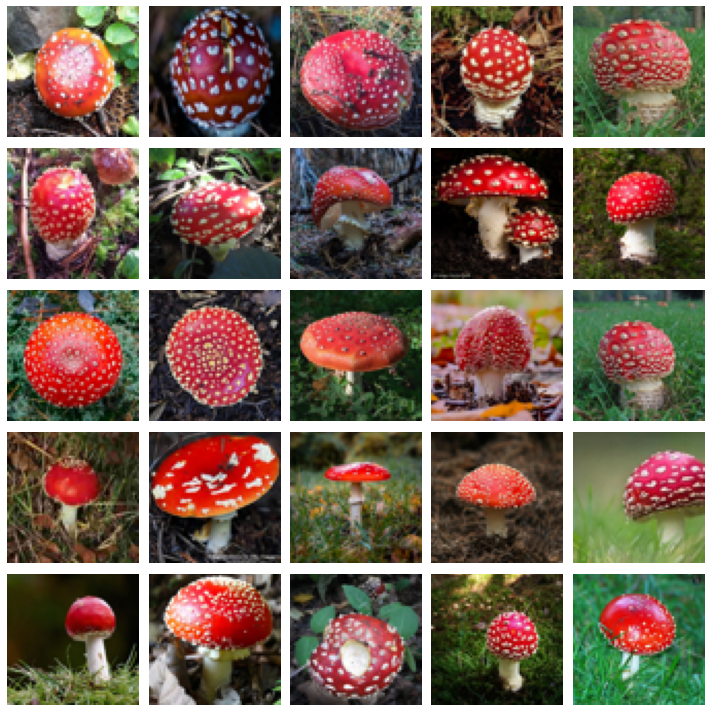

In [15]:
raw_amanitas_path = "datasets/amanita_raw"
files = os.listdir(raw_amanitas_path)
load_amanita = lambda file: jnp.array(Image.open(os.path.join(raw_amanitas_path, file)).resize((64, 64)))
images = jnp.array(list(map(load_amanita, files)))
plot_samples(jkey(42), images, subplots_shape=(5, 5))

Sytuacja z treningiem GAN'a na muchomorach nie poprawiła się znacząco w stosunku do galaktyk. Udało mi sie w pewien sposób dobrac hiperparametry zeby trening na przestrzeni kilkuset epok miał sens, a wyniki najlepszego z nich (z generatorem w wersji II z interpolacją) przedstawiam ponizej.  
Metryki:  
<img src="checkpoints/amanita/seed_22236/phase_1/metrices/metrices_800.png" style="width:300px;">

Przykładowe muchomory wygenerowane po 800 epokach:  
<img src="checkpoints/amanita/seed_22236/phase_1/generated/checkpoint_800.png" style="width:300px;">

Zmieniłem na tym etapie sposób zapisu obrazków generowanych na podstawie `MONITOR_VECTORS`, dzięki czemu łatwiej je przeglądac. Jak widac, muchomory nie są najlepszej jakości, jednak da się wyróznic charakterystyczny czerwony kapelusz z białymi plamkami, oraz przewazającą ilośc zieleni w dolnej części kazdego z obrazków -> grzyby w srodowisku naturalnym, takie jakie w większości znalazły się w moim datasetcie wyrastają z trawy. Jednak kształt krzywych *loss* nie jest idealny, sieci nie rywalizują, dyskryminator szybko zyskał przewagę i utknął w minimum lokalnym, a generator powoli uczył się generowc przykłady z tego obszaru.

Wyniki z zastosowaniem generatora wersji I (bez interpolacji) okazały się gorsze po takiej samej liczbie epok. Najbardziej obiecujące "grzyby" generowane były w okolicach 200 epoki.

Metryki:  
<img src="checkpoints/amanita/seed_22237/phase_1/metrices/metrices.png" style="width:300px;">

Przykładowe muchomory wygenerowane po 200 epokach:  
<img src="checkpoints/amanita/seed_22237/phase_1/generated/checkpoint_200.png" style="width:300px;">

### Eksperymenty na zbiorze *anime5000*

Mój ostatni zryw motywacji w celu osiągnięcia zadowalających wyników, to było uzycie gotowego datasetu wysokiej jakości. Pobrałem dataset [Anime Face Dataset](https://www.kaggle.com/datasets/splcher/animefacedataset) składający się w orginale z prawie 64 000 obrazków twarzy anime i ograniczyłem go do 5 000 obrazków, aby trening zajął rozsądną ilośc czasu. Niestety zaden z 2 zaimplementowanych modeli generatora nie poradził sobie z zadaniem generowania twarzy anime, nie udało mi się doprowadzic aby krzywe *loss* się zbiegły. Wyników nie prezentuję poniewaz były tak złe ze od razu je usunąłem (a tak naprawdę miałem problemy z ilością pamięci na maszynie której uzywałem do treningu, stąd przedwczesne usunięcie zapisanych rezultatów). 

### Ciąg dalszy raportu w pliku `TrainingGAN/raport_part2.ipynb`